# Alchemical Protein Mutations

In this tutorial you will learn how to use BioSimSpace's mapping functionality to set up alchemical calculations in order to compute the change in the binding affinity of a ligand as a result of a protein mutation. Specifically, we are going to focus on two proteins, first a set up of a single alchemical point mutation on ubiquitin, and second a set up on [aldose reductase](https://en.wikipedia.org/wiki/Aldose_reductase) (AR), which is a drug target for the treatment of diabetic nephropathy. It is recommended to complete [previous BioSimSpace tutorials](https://github.com/OpenBioSim/biosimspace_tutorials) before attempting this one.

The relative change in the binding affinity as a result of a mutation, $\Delta \Delta G_{mut}$ can be calculated from the difference between free energy of mutation in the holo (bound) and apo (unbound) simulation legs, i.e.:

![PFEP Tutorial Thermodynamic Cycle-1-2.png](<attachment:PFEP Tutorial Thermodynamic Cycle-1-2.png>)

$$
\Delta \Delta G_{mut} = \Delta G_{holo} - \Delta G_{apo}
$$

To get started, let's go through a simple example of generating the required input files in order to set up an alchemical mutation.

## Simple Case - Input File Generation

In order to create an alchemical protein system in BioSimSpace, we need two input protein structures, a wild-type and a mutant. We also need to make sure that the atom ordering between the two proteins is identical. Don't worry, this is an easy assumption to satisfy. We will load a structure `1UBQ` via [sire](https://sire.openbiosim.org/), which comes with bundled with BioSimSpace:
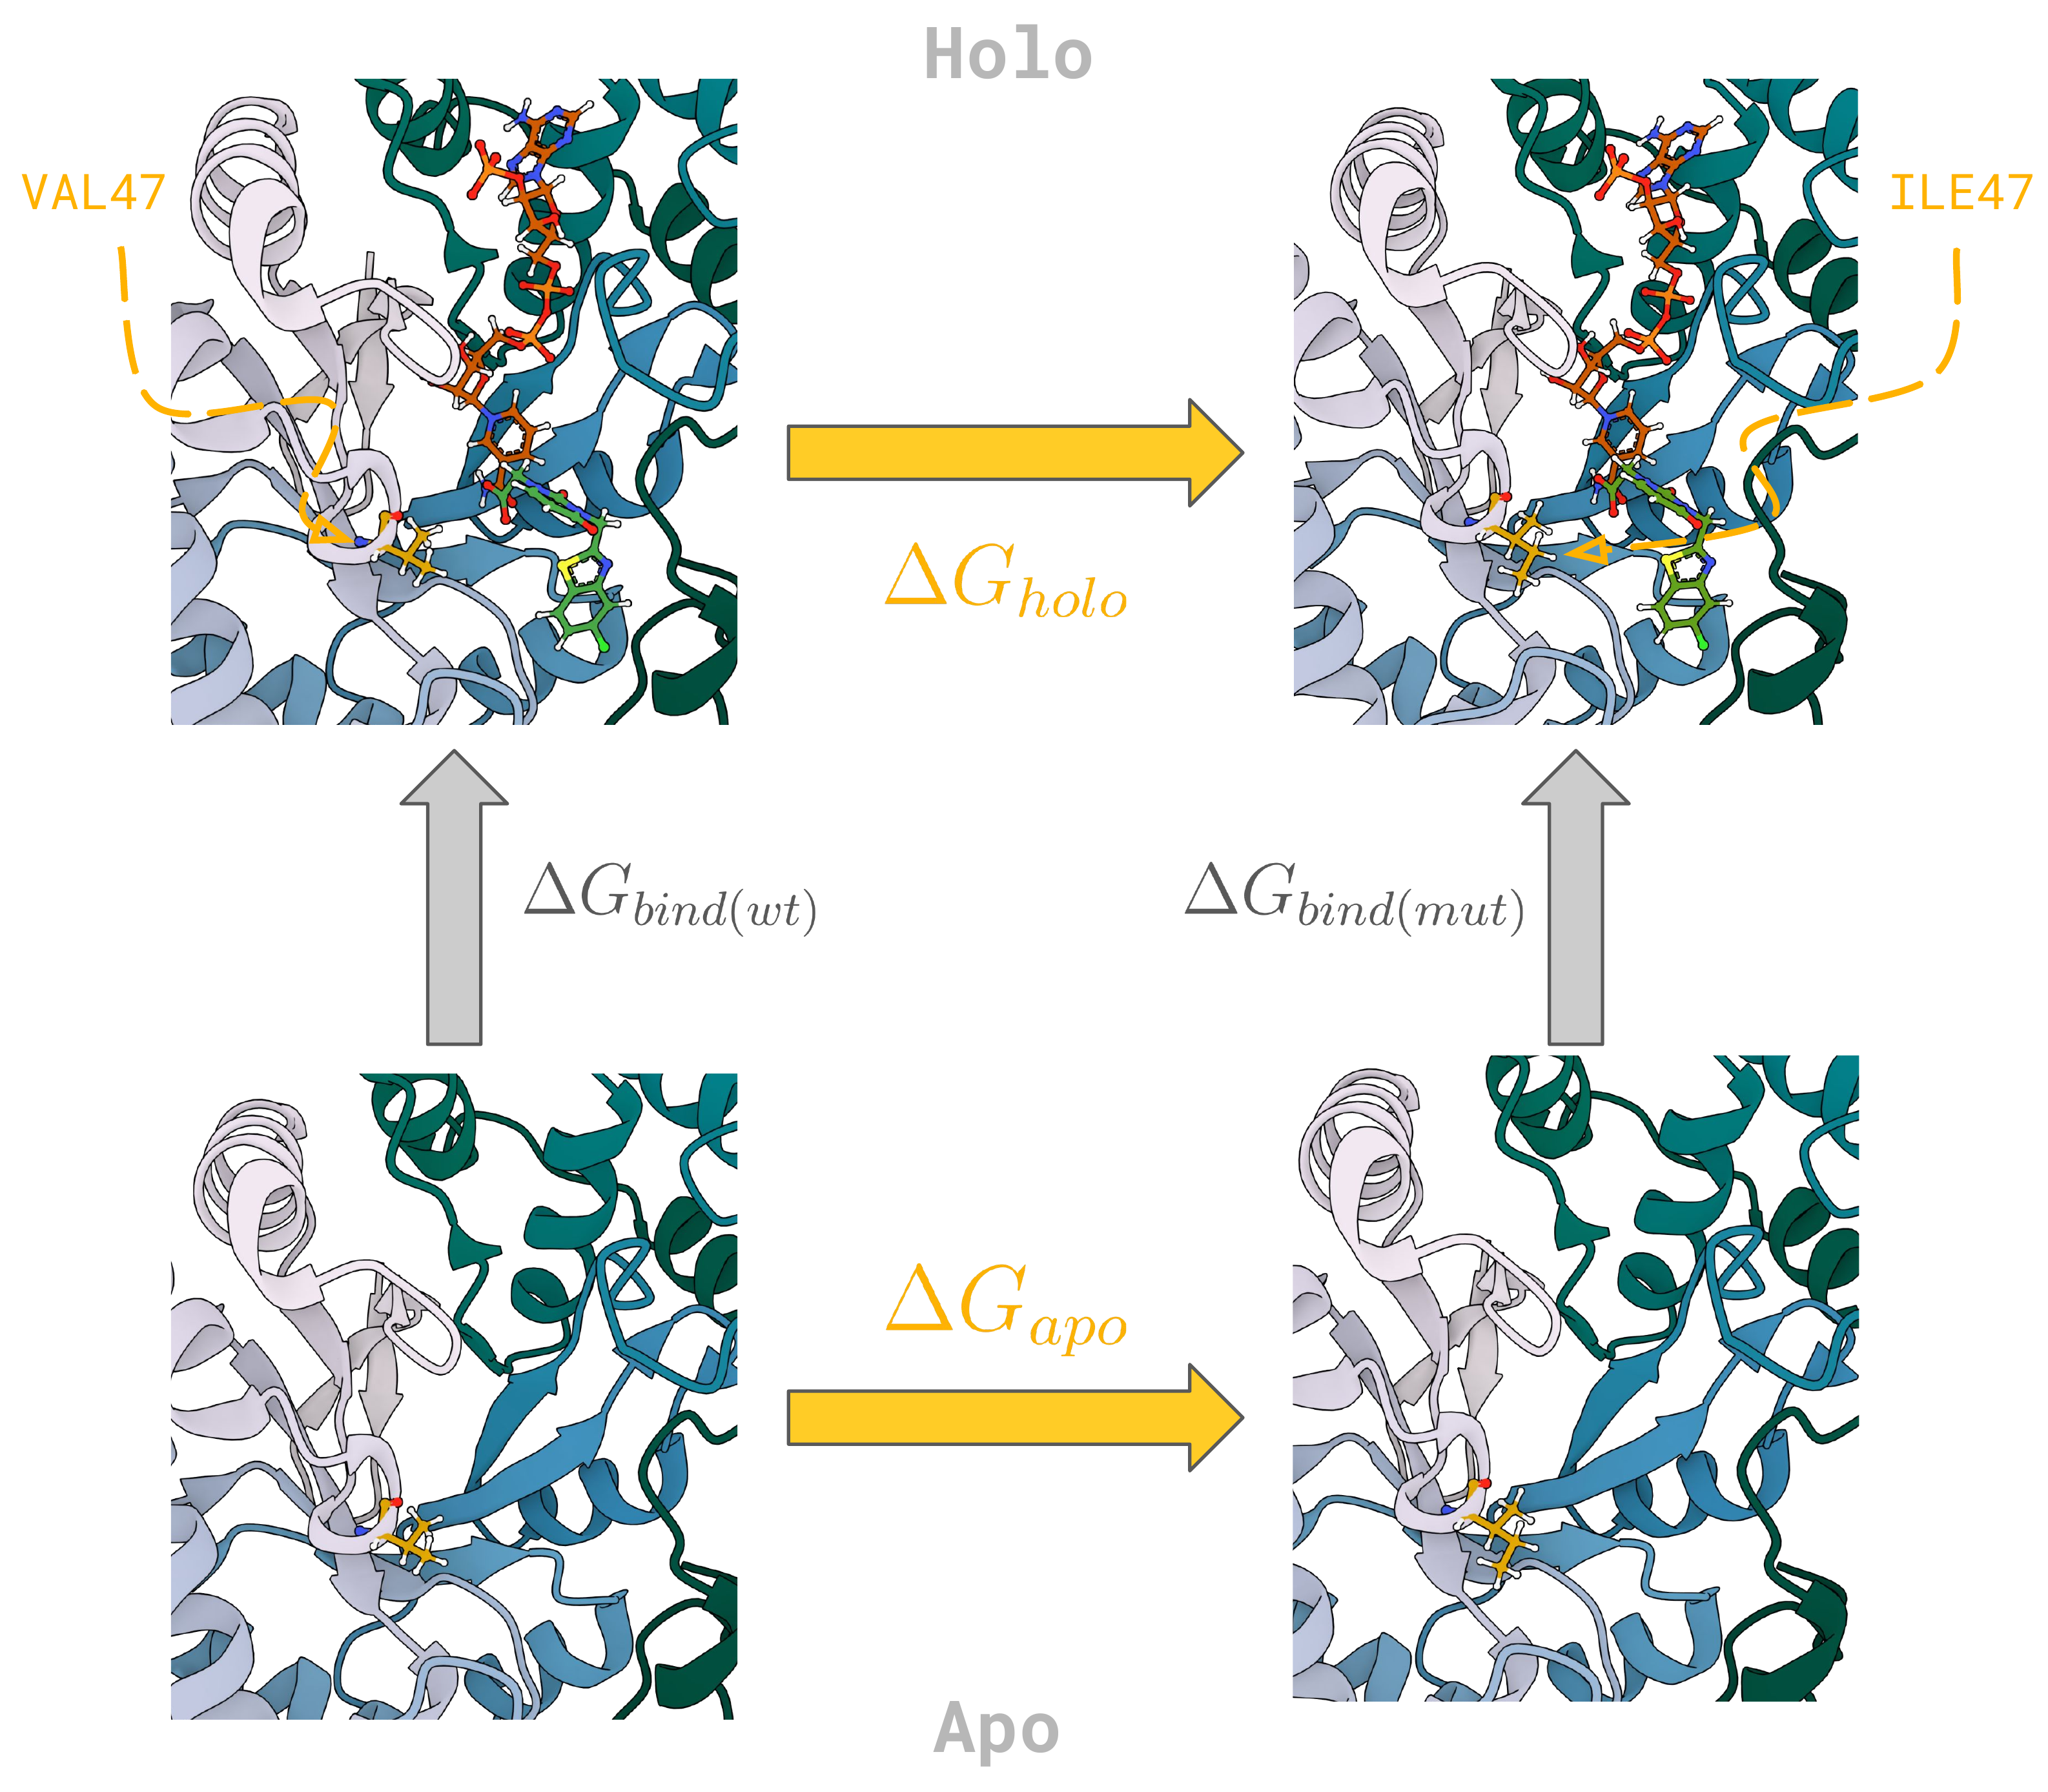

In [ ]:
import BioSimSpace as BSS
import sire as sr
mols = sr.load("1UBQ")

There are multiple of ways of generating a mutant structure from a wild-type protein, some examples are:
- [Pymol Mutagenesis Plugin](https://pymolwiki.org/index.php/Mutagenesis) (when exporting the mutant structure, you want to make you select 'retain atom ids' under 'PDB Options', or pass both input structures through *pdb4amber*)
- [HTMD](https://software.acellera.com/htmd/tutorials/system-building-protein-protein.html#mutate-modified-residues)
- [FoldX](https://foldxsuite.crg.eu/command/BuildModel)
- [pdb4amber](https://ambermd.org/tutorials/basic/tutorial9/index.php)

For this simple case we are going to use *pdb4amber* to mutate a threonine at position 9 to an alanine residue. First we are going to pass the wild-type protein from the crystal structure through *pdb4amber* in order create a consistent atom ordering between wild-type and mutant structures:

In [ ]:
!pdb4amber --reduce --dry --add-missing-atoms -o 1UBQ_dry_wt.pdb 1UBQ.pdb

In [ ]:
!pdb4amber -o protein_wt_amber.pdb protein_wt.pdb
!pdb4amber -o protein_mut_amber.pdb protein_mut.pdb

Next, we are going to create a mutant structure:

In [ ]:
!pdb4amber --reduce --dry -o 1UBQ_dry_t9a.pdb -m "9-ALA" --add-missing-atoms 1UBQ_dry_wt.pdb

<div class="alert alert-block alert-warning">
<b>Warning:</b> This is a simple, but ultimately a crude way of generating a mutant structure. Different factors such as sidechain rotomers, packing and protonation states need to be taken into the account in order to accurately and robustly describe the mutant end-state.
</div>

## Simple Case - Alchemical System Generation

Now that correct input files have been created, we can now proceed to create an alchemical protein in BioSimSpace. Let's load our two proteins:

In [ ]:
protein_wt = BSS.IO.readMolecules("1UBQ_dry_wt.pdb")[0]
protein_mut = BSS.IO.readMolecules("1UBQ_dry_t9a.pdb")[0]

Next, we want to parametrise them with our forcefield of choice:

In [ ]:
protein_wt = BSS.Parameters.ff14SB(protein_wt).getMolecule()
protein_mut = BSS.Parameters.ff14SB(protein_mut).getMolecule()

Now we want to compute the mapping between the two proteins, first let's figure out the residue index of our residue of interest (ROI):

In [ ]:
protein_wt.getResidues()[7:10]

In [ ]:
protein_mut.getResidues()[7:10]

We can see that the residue with the index value of 8 are different between the two proteins. Let's pass this value to the [`BioSimSpace.Align.matchAtoms`](https://biosimspace.openbiosim.org/api/generated/BioSimSpace.Align.matchAtoms.html#BioSimSpace.Align.matchAtoms) function:

In [ ]:
mapping = BSS.Align.matchAtoms(molecule0=protein_wt, molecule1=protein_mut, roi=[8])

<div class="alert alert-block alert-info">
<b>Note:</b> You can also pass multiple residues of interest indices to the mapping if you wish to mutate several residues simultaneously.
</div>

Now that the mapping has been computed, we can visualise it:

In [ ]:
BSS.Align.viewMapping(protein_wt, protein_mut, mapping, roi=8, pixels=500)

The computed atom mapping shows that both hydroxyl and methyl groups in the threonine side chain will be transformed into hydrogen atoms respectively. We can now proceed to align the two residues of interest:

In [ ]:
aligned_wt = BSS.Align.rmsdAlign(molecule0=protein_wt, molecule1=protein_mut, roi=[8])

Finally, we can create a merged alchemical protein system:

In [ ]:
merged_protein = BSS.Align.merge(aligned_wt, protein_mut, mapping, roi=[8])

The alchemical protein can now be solvated, ionised and exported to different file formats, for example GROMACS or [SOMD2, our OpenMM-based FEP engine](https://github.com/OpenBioSim/somd2):

In [ ]:
merged_system = merged_protein.toSystem()

# solvate the system with the padding of 15 angstroms
padding = 15 * BSS.Units.Length.angstrom
box_min, box_max = merged_system.getAxisAlignedBoundingBox()
box_size = [y - x for x, y in zip(box_min, box_max)]
box_sizes = [x + padding for x in box_size]

box, angles = BSS.Box.rhombicDodecahedronHexagon(max(box_sizes))
solvated_system = BSS.Solvent.tip3p(molecule=merged_system, box=box, angles=angles, ion_conc=0.15)

In [ ]:
# export the solvated system to GROMACS input files
BSS.IO.saveMolecules("apo_ubiquitin_t9a", solvated_system, ["gro87", "grotop"])

In [ ]:
# export the solvated system to SOMD2 input file
BSS.Stream.save(solvated_system, "apo_ubiquitin_t9a")

# Aldose Reductase - Alchemical System Generation

## Apo System

Now we are going to focus on the aldose reductase system and set up an alchemical transformation in both apo and holo forms of the protein. The input files (2PDG_8.0) were taken from the SI of a [paper by Aldeghi et. al](https://pubs.acs.org/doi/10.1021/acscentsci.8b00717), residue 47 mutated via PyMol (V47I), and standardised via *pdb4amber*.

In [ ]:
protein_wt = BSS.IO.readMolecules(BSS.IO.expand(BSS.tutorialUrl(),  "aldose_reductase_dry.pdb"))[0]
protein_mut = BSS.IO.readMolecules(BSS.IO.expand(BSS.tutorialUrl(), "aldose_reductase_v47i_dry.pdb"))[0]

We can use `ensure_compatible=False` in order to get tLEaP to re-add the hydrogens for us:

In [ ]:
protein_wt = BSS.Parameters.ff14SB(protein_wt, ensure_compatible=False).getMolecule()
protein_mut = BSS.Parameters.ff14SB(protein_mut, ensure_compatible=False).getMolecule()

In [ ]:
protein_wt.getResidues()[44:47]

In [ ]:
protein_mut.getResidues()[44:47]

This time we are going to automatically detect the different residues between the two proteins:

In [ ]:
roi = []
for i, res in enumerate(protein_wt.getResidues()):
    if res.name() != protein_mut.getResidues()[i].name():
        print(res, protein_mut.getResidues()[i])
        roi.append(res.index())

We can then pass these residue indices to the mapping function as before:

In [ ]:
mapping = BSS.Align.matchAtoms(molecule0=protein_wt, molecule1=protein_mut, roi=roi)

In [ ]:
BSS.Align.viewMapping(protein_wt, protein_mut, mapping, roi=roi[0], pixels=500)

The mapping shows that the perturbation will transform a hydrogen to a methyl group. Is this what we would expect for a valine to isoleucine transformation? If we are happy, we can proceed with the rest of the set up as before:

In [ ]:
aligned_wt = BSS.Align.rmsdAlign(molecule0=protein_wt, molecule1=protein_mut, roi=roi)
merged_protein = BSS.Align.merge(aligned_wt, protein_mut, mapping, roi=roi)

In [ ]:
merged_system = merged_protein.toSystem()

In [ ]:
padding = 15 * BSS.Units.Length.angstrom

box_min, box_max = merged_system.getAxisAlignedBoundingBox()
box_size = [y - x for x, y in zip(box_min, box_max)]
box_sizes = [x + padding for x in box_size]

In [ ]:
box, angles = BSS.Box.rhombicDodecahedronHexagon(max(box_sizes))
solvated_system = BSS.Solvent.tip3p(molecule=merged_system, box=box, angles=angles, ion_conc=0.15)

In [ ]:
# export the solvated system to GROMACS input files
BSS.IO.saveMolecules("apo_aldose_reductase_v47i", solvated_system, ["gro87", "grotop"])

In [ ]:
# export the solvated system to SOMD2 input file
BSS.Stream.save(solvated_system, "apo_aldo_reductase_v47i")

## Holo System

To set up a holo (bound) system, we are going to load in the associated ligand and the cofactor of aldose reductase:

In [ ]:
ligand_47d = BSS.IO.readMolecules(BSS.IO.expand(BSS.tutorialUrl(), ["ligand_47_gaff2.gro", "ligand_47_gaff2.top"]))[0]
cofactor_nap = BSS.IO.readMolecules(BSS.IO.expand(BSS.tutorialUrl(), ["cofactor_nap_gaff2.gro", "cofactor_nap_gaff2.top"]))[0]

We can use BioSimSpace's Amber parametrisation pipeline if we wish to, but in this case the ligands have been parametrised for us so we can skip the following cell:

In [ ]:
ligand_47d = BSS.Parameters.gaff2(ligand_47d, charge_method="BCC", net_charge=-1).getMolecule()
cofactor_nap = BSS.Parameters.gaff2(cofactor_nap, charge_method="BCC", net_charge=-4).getMolecule()

We can simply add the ligands to our alchemical protein in order to create an alchemical holo system. This way we are assuming that the ligands are already placed correctly with respect to the protein:

In [ ]:
merged_system = merged_protein + ligand_47d + cofactor_nap

As before we can now proceed to solvate, ionise and export our prepared system or use BioSimSpace's functionallity to [further set up and execute the alchemical simulations](https://github.com/OpenBioSim/biosimspace_tutorials/tree/main/04_fep).

In [ ]:
padding = 15 * BSS.Units.Length.angstrom

box_min, box_max = merged_system.getAxisAlignedBoundingBox()
box_size = [y - x for x, y in zip(box_min, box_max)]
box_sizes = [x + padding for x in box_size]

box, angles = BSS.Box.rhombicDodecahedronHexagon(max(box_sizes))
solvated_system = BSS.Solvent.tip3p(molecule=merged_system, box=box, angles=angles, ion_conc=0.15)

BSS.IO.saveMolecules("holo_aldose_reductase_v47i", solvated_system, ["gro87", "grotop"])